In [4]:
import pandas as pd

In [5]:
base_df = pd.read_csv('Prot2text_UniProt_final.csv')
qa_df = pd.read_csv('qa_evifunc_tight.csv')

# Main Data

In [ ]:
base_df = pd.read_csv('Prot2text_UniProt_final.csv')
base_df.info()

Total rows: 256690
Splits: split
train    256690
Name: count, dtype: int64

Average sequence length: 366.6645681561416
Average function text length (words): 31.462702092017608

Evidence coverage (% of rows):
 GO_MF_json                   91.520901
GO_BP_json                   86.503954
GO_CC_json                   83.875102
Subcellular_location_json    65.356656
EC number                    55.138883
Catalytic_Activity_json      51.777631
Binding_site_json            45.150571
Pathway_json                 26.760295
UniPathway_raw               26.023998
Cofactor_json                25.417819
DomainFT_json                24.595426
Reactome_raw                  7.195450
Topological_domain_json       5.210176
Motif_json                    4.682302
DNA_binding_json              1.903463
dtype: float64

Average # of supports per protein:
EC_number          0.592793
RHEA_ids           0.000000
GO_MF_ids          2.256029
GO_BP_ids          2.161736
GO_CC_ids          1.483151
Pathway_levels 

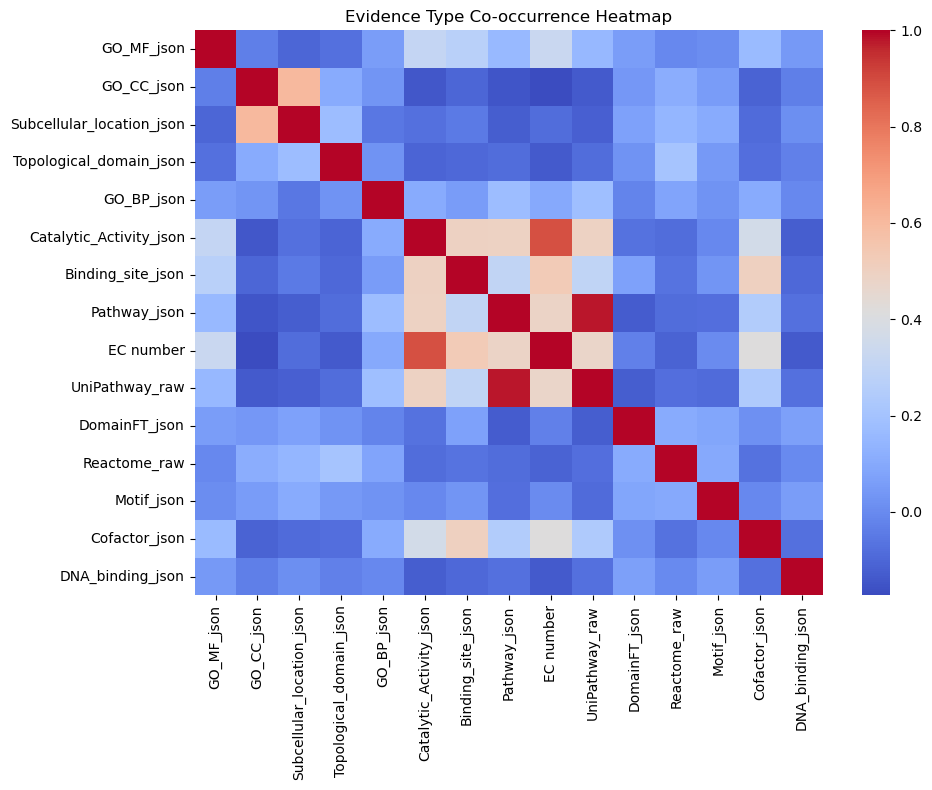

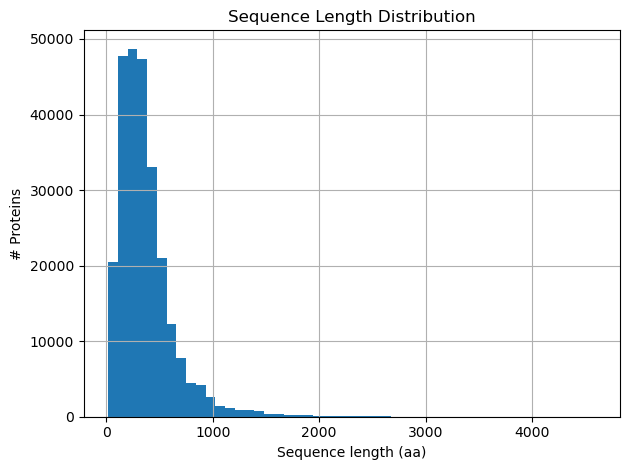

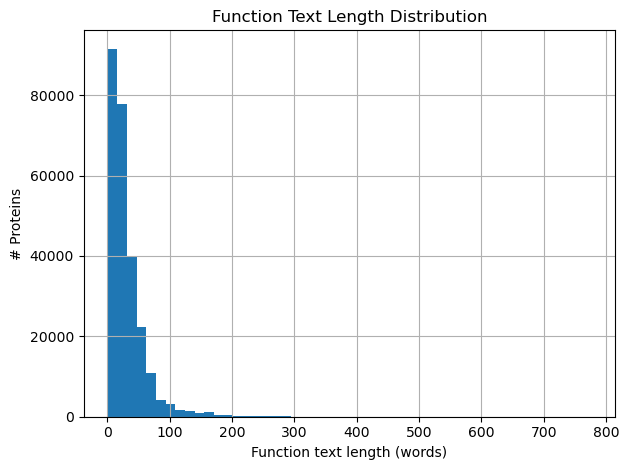

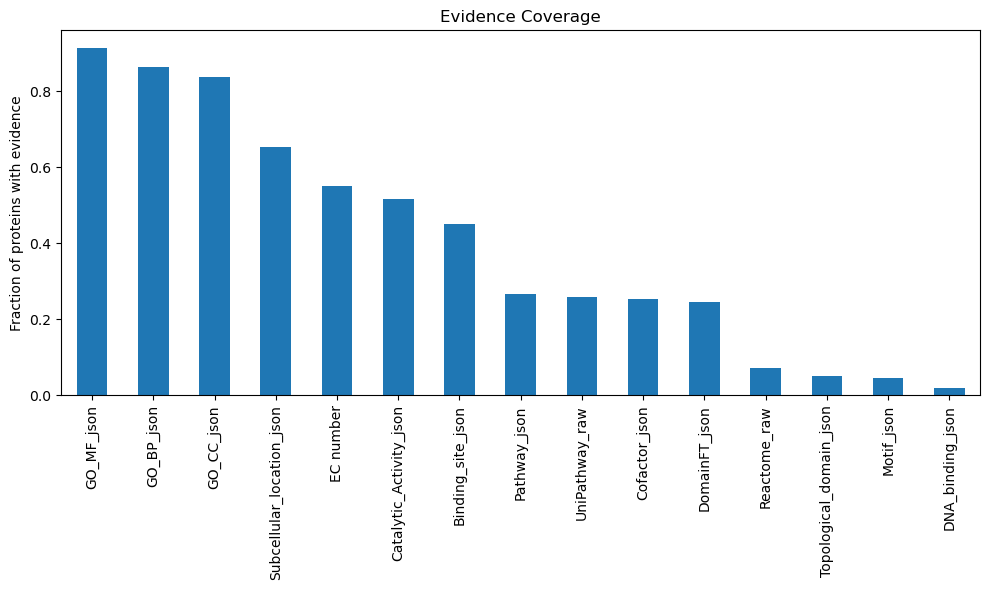

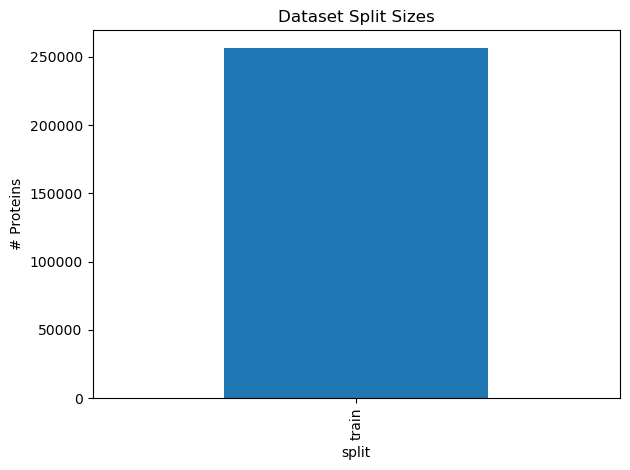

In [7]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# === Load dataset ===
df = qa_df.copy()

print("Total rows:", len(df))
print("Splits:", df["split"].value_counts())

# === 1. Basic stats ===
df["seq_len"] = df["sequence"].str.len()
df["func_len"] = df["answer"].str.split().apply(len)

print("\nAverage sequence length:", df["seq_len"].mean())
print("Average function text length (words):", df["func_len"].mean())

# === 2. Evidence coverage ===
def extract_counts(cov_str):
    try:
        cov = json.loads(cov_str)
        return cov.get("evidence_counts", {})
    except:
        return {}

coverage_df = df["coverage_json"].apply(extract_counts)
coverage_expanded = pd.DataFrame(list(coverage_df)).fillna(0).astype(int)

evidence_presence = (coverage_expanded > 0).mean().sort_values(ascending=False)
print("\nEvidence coverage (% of rows):\n", evidence_presence*100)

# === 3. Gold supports distribution ===
def extract_supports(gs_str):
    try:
        gs = json.loads(gs_str)
        return {k: len(v) if isinstance(v, list) else 0 for k, v in gs.items()}
    except:
        return {}

support_df = df["gold_supports_json"].apply(extract_supports)
support_expanded = pd.DataFrame(list(support_df)).fillna(0).astype(int)

print("\nAverage # of supports per protein:")
print(support_expanded.mean())

# === 4. Co-occurrence heatmap ===
co_occurrence = (coverage_expanded > 0).astype(int).corr()
plt.figure(figsize=(10,8))
sns.heatmap(co_occurrence, cmap="coolwarm", annot=False)
plt.title("Evidence Type Co-occurrence Heatmap")
plt.tight_layout()
plt.savefig("evidence_cooccurrence.png")

# === 5. Histograms ===
plt.figure()
df["seq_len"].hist(bins=50)
plt.xlabel("Sequence length (aa)")
plt.ylabel("# Proteins")
plt.title("Sequence Length Distribution")
plt.tight_layout()
plt.savefig("seq_length_hist.png")

plt.figure()
df["func_len"].hist(bins=50)
plt.xlabel("Function text length (words)")
plt.ylabel("# Proteins")
plt.title("Function Text Length Distribution")
plt.tight_layout()
plt.savefig("func_length_hist.png")

# === 6. Evidence coverage bar chart ===
plt.figure(figsize=(10,6))
evidence_presence.plot(kind="bar")
plt.ylabel("Fraction of proteins with evidence")
plt.title("Evidence Coverage")
plt.tight_layout()
plt.savefig("evidence_coverage.png")

# === 7. Split sizes bar chart ===
plt.figure()
df["split"].value_counts().plot(kind="bar")
plt.ylabel("# Proteins")
plt.title("Dataset Split Sizes")
plt.tight_layout()
plt.savefig("split_sizes.png")

print("\nPlots saved:")
print("- evidence_cooccurrence.png")
print("- seq_length_hist.png")
print("- func_length_hist.png")
print("- evidence_coverage.png")
print("- split_sizes.png")

# === 8. Summary table ===
summary_table = pd.DataFrame({
    "Total proteins":[len(df)],
    "Unique entries":[df['entry'].nunique()],
    "Avg sequence length":[df["seq_len"].mean()],
    "Avg function length (words)":[df["func_len"].mean()],
    "With EC":[(support_expanded["EC_number"]>0).mean()*100],
    "With GO MF":[(support_expanded["GO_MF_ids"]>0).mean()*100],
    "With GO BP":[(support_expanded["GO_BP_ids"]>0).mean()*100],
    "With GO CC":[(support_expanded["GO_CC_ids"]>0).mean()*100]
})
print("\nSummary Table:\n", summary_table.T)

In [9]:
!pip isntall textstat

ERROR: unknown command "isntall" - maybe you meant "install"


In [10]:
import numpy as np
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import textstat

# === 9. Question vs Answer Lengths ===
df["question_len"] = df["question"].str.split().apply(len)
print("\nAvg Q length (words):", df["question_len"].mean())
print("Avg A length (words):", df["func_len"].mean())
print("Q/A length ratio mean:", (df["question_len"]/df["func_len"]).mean())

# Plot distribution
plt.figure()
plt.scatter(df["question_len"], df["func_len"], alpha=0.2, s=5)
plt.xlabel("Question length (words)")
plt.ylabel("Answer length (words)")
plt.title("Q vs A Length Scatter")
plt.tight_layout()
plt.savefig("qa_length_scatter.png")

# === 10. Function Vocabulary Statistics ===
all_func_tokens = " ".join(df["answer"].astype(str)).split()
vocab = Counter(all_func_tokens)
print("\nFunction vocab size:", len(vocab))
print("Top 20 most common function tokens:", vocab.most_common(20))

# === 11. Readability Scores of Answers ===
df["readability_fkgl"] = df["answer"].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
df["readability_flesch"] = df["answer"].apply(lambda x: textstat.flesch_reading_ease(str(x)))
print("\nAnswer readability (Flesch-Kincaid grade): mean =", df["readability_fkgl"].mean())
print("Answer readability (Flesch reading ease): mean =", df["readability_flesch"].mean())

# === 12. Q/A Semantic Overlap (token-level Jaccard) ===
def jaccard(a, b):
    sa, sb = set(a.split()), set(b.split())
    if not sa or not sb: return 0.0
    return len(sa & sb) / len(sa | sb)

df["qa_jaccard"] = df.apply(lambda r: jaccard(r["question"], r["answer"]), axis=1)
print("\nQ/A token overlap (Jaccard): mean =", df["qa_jaccard"].mean())

# Plot histogram
plt.figure()
df["qa_jaccard"].hist(bins=50)
plt.xlabel("Q–A Jaccard overlap")
plt.ylabel("# Proteins")
plt.title("Distribution of Q/A Overlap")
plt.tight_layout()
plt.savefig("qa_overlap_hist.png")

# === 13. BLEU score of Question->Answer (sanity check) ===
smooth = SmoothingFunction().method1
df["qa_bleu"] = df.apply(lambda r: sentence_bleu(
    [r["answer"].split()], r["question"].split(), smoothing_function=smooth
), axis=1)
print("\nMean Q->A BLEU (sanity check, not a true eval metric):", df["qa_bleu"].mean())

# === 14. Split-wise Function Diversity ===
diversity = df.groupby("split")["answer"].apply(
    lambda s: len(set(" ".join(s).split())) / len(" ".join(s).split())
)
print("\nSplit-wise lexical diversity of function text:\n", diversity)

# === 15. Evidence Density vs Answer Length ===
df["evidence_items"] = df["coverage_json"].apply(lambda x: json.loads(x)["totals"]["evidence_items"])
corr = np.corrcoef(df["evidence_items"], df["func_len"])[0,1]
print("\nCorrelation between #evidence items and answer length:", corr)

plt.figure()
plt.scatter(df["evidence_items"], df["func_len"], alpha=0.2, s=5)
plt.xlabel("# Evidence items")
plt.ylabel("Answer length (words)")
plt.title("Evidence vs Answer Length")
plt.tight_layout()
plt.savefig("evidence_vs_answer_len.png")


ModuleNotFoundError: No module named 'textstat'

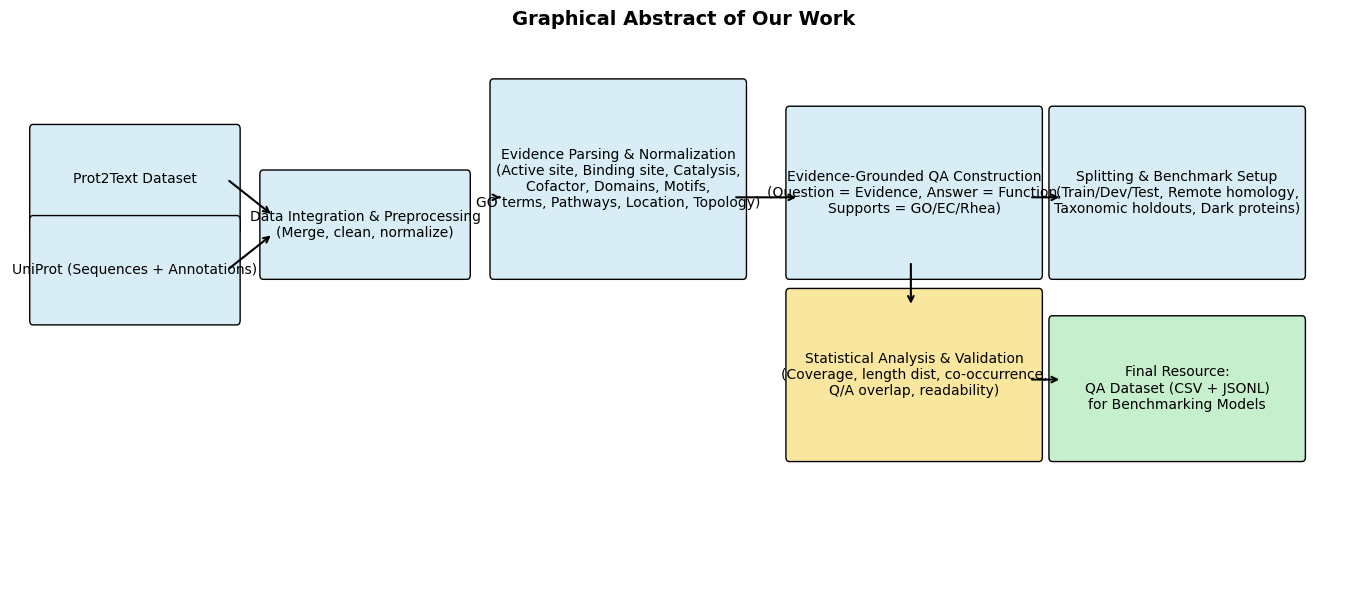

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def add_block(ax, text, xy, width=2.8, height=0.8, color="#d9edf7"):
    """Draw a rounded block with text"""
    x, y = xy
    box = FancyBboxPatch((x, y), width, height,
                         boxstyle="round,pad=0.2,rounding_size=0.05",
                         ec="black", fc=color)
    ax.add_patch(box)
    ax.text(x+width/2, y+height/2, text, ha="center", va="center", fontsize=10, wrap=True)

fig, ax = plt.subplots(figsize=(14,6))

# Blocks
add_block(ax, "Prot2Text Dataset", (0,4))
add_block(ax, "UniProt (Sequences + Annotations)", (0,3))

add_block(ax, "Data Integration & Preprocessing\n(Merge, clean, normalize)", (3.5,3.5))

add_block(ax, "Evidence Parsing & Normalization\n(Active site, Binding site, Catalysis,\nCofactor, Domains, Motifs,\nGO terms, Pathways, Location, Topology)", (7,3.5), width=3.5, height=1.8)

add_block(ax, "Evidence-Grounded QA Construction\n(Question = Evidence, Answer = Function,\nSupports = GO/EC/Rhea)", (11.5,3.5), width=3.5, height=1.5)

add_block(ax, "Splitting & Benchmark Setup\n(Train/Dev/Test, Remote homology,\nTaxonomic holdouts, Dark proteins)", (15.5,3.5), width=3.5, height=1.5)

add_block(ax, "Statistical Analysis & Validation\n(Coverage, length dist, co-occurrence,\nQ/A overlap, readability)", (11.5,1.5), width=3.5, height=1.5, color="#f9e79f")

add_block(ax, "Final Resource:\nQA Dataset (CSV + JSONL)\nfor Benchmarking Models", (15.5,1.5), width=3.5, height=1.2, color="#c6efce")

# Arrows
for (x1,y1),(x2,y2) in [((2.8,4.4),(3.5,4.0)),
                        ((2.8,3.4),(3.5,3.8)),
                        ((6.9,4.2),(7,4.2)),
                        ((10.5,4.2),(11.5,4.2)),
                        ((15,4.2),(15.5,4.2)),
                        ((13.2,3.5),(13.2,3.0)),
                        ((15,2.2),(15.5,2.2))]:
    ax.annotate("", xy=(x2,y2), xytext=(x1,y1),
                arrowprops=dict(arrowstyle="->", lw=1.5))

ax.set_xlim(-0.5, 20)
ax.set_ylim(0,6)
ax.axis("off")
plt.title("Graphical Abstract of Our Work", fontsize=14, weight="bold")
plt.tight_layout()
plt.savefig("graphical_abstract.png", dpi=300)
plt.show()
